# Dorothea

There are two ways of describing the city of Dorothea: you can say that four aluminum towers rise from its walls flanking seven gates with spring-operated drawbridges that span the moat whose water feeds four green canals which cross the city, dividing it into nine quarters, each with three hundred houses and seven hundred chimneys. And bearing in mind that the nubile girls of each quarter marry youths of other quarters and their parents exchange the goods that each family holds in monopoly -- bergamot, sturgeon roe, astrolabes, amethysts -- you can then work from these facts until you learn everything you wish about the city in the past, present, and future. Or else you can say, like the camel driver who took me there: “I arrived here in my first youth, one morning, many people were hurrying along the streets toward the market, the women had fine teeth and looked you straight in the eye, three soldiers on a platform played the trumpet, and all around wheels turned and colored banners fluttered in the wind. Before then I had known only the desert and the caravan routes. In the years that followed, my eyes returned to contemplate the desert expanses and the caravan routes; but now I know this path is only one of the many that opened before me on that morning in Dorothea.”

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


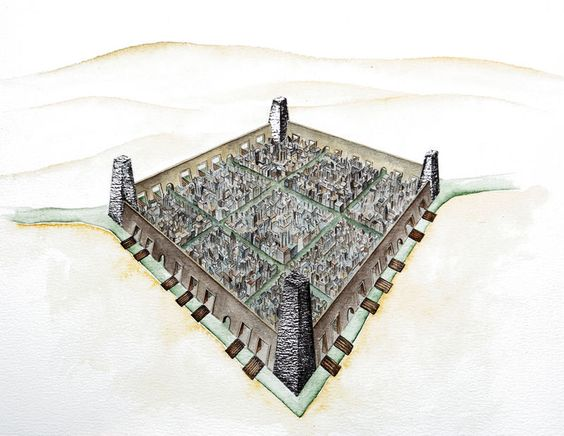

In [4]:
Image(filename='../Images/Dorothea.jpg') 

## This notebook plays with NEXT MC data stored in the Nh5 DST

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [39]:
from PlotUtil import *

Access the Nh5 DST (generated by DIOMIRA)

In [6]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/'

In [7]:
ffile="WF_Tl_0.h5"

In [8]:
h5pd = pd.HDFStore(path+ffile)

In [9]:
h5pd

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Tl_0.h5
/Detector/DetectorGeometry            series_table (typ->appendable,nrows->7,ncols->1,indexers->[index],dc->[values])                                                                                                                                             
/EnergyPlane/FEE                      series_table (typ->appendable,nrows->12,ncols->1,indexers->[index],dc->[values])                                                                                                                                            
/MC/MCTracks                          frame_table [0.0.0] (typ->generic,nrows->4311,ncols->13,indexers->[index],dc->[event_indx,mctrk_indx,particle_name,pdg_code,initial_vertex,final_vertex,momentum,energy,nof_hits,hit_indx,hit_position,hit_time,hit_energy])
/Sensors/DataPMT                      frame_table  (typ->appendable,nrows->12,ncols->6,indexer

In [11]:
dfPMT = h5pd.select('Sensors/DataPMT')

In [12]:
dfPMT

,active,adc_to_pes,channel,gain,x,y
0,1,20.0,0,4500000.0,23.9414,65.7785
1,1,20.0,1,4500000.0,-68.9365,-12.1554
2,1,20.0,2,4500000.0,44.9951,-53.6231
3,1,20.0,3,4500000.0,0.0000,185.0000
4,1,20.0,5,4500000.0,-118.9160,141.7180
5,1,20.0,6,4500000.0,-182.1890,32.1249
6,1,20.0,8,4500000.0,-160.2150,-92.5000
7,1,20.0,9,4500000.0,-63.2737,-173.8430
8,1,20.0,10,4500000.0,63.2737,-173.8430
9,1,20.0,12,4500000.0,160.2150,-92.5000


In [13]:
dfsipm = h5pd.select('Sensors/DataSiPM')

In [14]:
dfsipm

,active,adc_to_pes,channel,gain,x,y
0,1,1.0,1001,1.0,235.0,55.0
1,1,1.0,1002,1.0,235.0,65.0
2,1,1.0,1003,1.0,235.0,75.0
3,1,1.0,1004,1.0,235.0,85.0
4,1,1.0,1005,1.0,235.0,95.0
5,1,1.0,1006,1.0,235.0,105.0
6,1,1.0,1007,1.0,235.0,115.0
7,1,1.0,1008,1.0,225.0,45.0
8,1,1.0,1009,1.0,225.0,55.0
9,1,1.0,1010,1.0,225.0,65.0


In [15]:
dfgeom= h5pd.select('/Detector/DetectorGeometry')

In [16]:
dfgeom

xdet_min   -198.0
xdet_max    198.0
ydet_min   -198.0
ydet_max    198.0
zdet_min      0.0
zdet_max    532.0
R           198.0
dtype: float64

In [17]:
dfee= h5pd.select('/EnergyPlane/FEE')

In [18]:
dfee

offset           0.000000e+00
pmt_gain         4.500000e+06
V_gain           4.005443e-14
R                3.765117e-13
time_step        1.000000e+00
time_daq         2.500000e+01
freq_LPF         3.000000e-03
freq_HPF         1.092347e-05
LSB              4.882812e-10
volts_to_adc     3.906250e-04
noise_fee_rms    7.000000e-10
noise_adc        1.792000e+00
dtype: float64

In [20]:
h5pd.close()

In [21]:
dfee

offset           0.000000e+00
pmt_gain         4.500000e+06
V_gain           4.005443e-14
R                3.765117e-13
time_step        1.000000e+00
time_daq         2.500000e+01
freq_LPF         3.000000e-03
freq_HPF         1.092347e-05
LSB              4.882812e-10
volts_to_adc     3.906250e-04
noise_fee_rms    7.000000e-10
noise_adc        1.792000e+00
dtype: float64

In [22]:
h5f = tb.open_file(path+ffile, "r")

In [23]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Tl_0.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=9, complib='blosc', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(10, 12, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 2, 24000)
/sipmrd (EArray(10, 1792, 600), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 109, 600)
/Detector (Group) ''
/EnergyPlane (Group) ''
/MC (Group) ''
/MC/MCTracks (Table(4311,)) 'MCTracks'
  description := {
  "event_indx": Int16Col(shape=(), dflt=0, pos=0),
  "mctrk_indx": Int16Col(shape=(), dflt=0, pos=1),
  "particle_name": StringCol(itemsize=10, shape=(), dflt='', pos=2),
  "pdg_code": Int16Col(shape=(), dflt=0, pos=3),
  "initial_vertex": Float64Col(shape=(3,), dfl

In [24]:
 mctrk = h5f.root.MC.MCTracks

In [25]:
mctrka = mctrk.read()

In [26]:
mctrka

array([ (0, 0, 'gamma', 22, [335.00167280977445, 0.0005308107367454436, 155.00113023759252], [-78.64476091352176, -84.14863906196295, 435.6569322117802], [-1.105297136002266, -0.7200341629991703, -2.2573218554643493], 0.004774700000000003, 1, 0, [-78.64476091352176, -84.14863906196295, 435.6569322117802], 317624902988.2688, 0.004774700000000003),
       (0, 1, 'gamma', 22, [-78.64476091352176, -84.14863906196295, 435.6569322117802], [-81.19535895557861, -70.11710575742109, 439.5501673425123], [-0.005138229405141221, 0.028266796976945358, -0.00784299795577526], 0.00020837, 1, 0, [-81.19535895557861, -70.11710575742109, 439.5501673425123], 317624902988.3181, 0.00020837),
       (0, 2, 'e-', 11, [-81.19535895557861, -70.11710575742109, 439.5501673425123], [-81.25245331142999, -70.1302910990934, 439.57199659594414], [-0.12857203425484529, 0.10401542988376529, -0.0612213241727414], 0.02957293, 4, 0, [-81.24617639251457, -70.07599419238193, 439.57436475681243], 317624902988.31885, 0.00868128

In [40]:
pmtrd = h5f.root.pmtrd

In [41]:
pmtrd

/pmtrd (EArray(10, 12, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 2, 24000)

In [42]:
h5f2 = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF_Tl_0.h5', "r")

In [43]:
pmtrd = h5f2.root.pmtrd

In [44]:
pmtrd

/pmtrd (EArray(99, 12, 599999), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 131072)

In [45]:
def sensor_energy_pes(evector = pmtrd, nevents=10):
    """
    Creates a DF for the PMTs with the energy of each sensor in PES
    """     
    nev = min(nevents,pmtrd.shape[0])
    npmt = pmtrd.shape[1]
    print("number of sensor = {}".format(npmt))
    print("running over {} events".format(nev))
        
    ene_pes = np.zeros((nevents,npmt))
    print("shape of ene_pes ={}".format(ene_pes.shape))
    for i in range(nev):
        for j in range(npmt):
            pmtwf = pmtrd[i, j]
            ene = sum(pmtwf)
            ene_pes[i,j] = ene
            
         
    return pd.DataFrame(ene_pes)

In [46]:
epsdf = sensor_energy_pes(evector = pmtrd, nevents=10)

number of sensor = 12
running over 10 events
shape of ene_pes =(10, 12)


In [47]:
epsdf

,0,1,2,3,4,5,6,7,8,9,10,11
0,4123.0,4081.0,4001.0,3522.0,3365.0,3428.0,3349.0,3405.0,3460.0,3453.0,3416.0,3439.0
1,6146.0,6169.0,6184.0,5252.0,5303.0,5312.0,5338.0,5418.0,5295.0,5224.0,5259.0,5286.0
2,21923.0,22199.0,22297.0,18772.0,18908.0,18764.0,18855.0,18919.0,19077.0,18813.0,18739.0,18934.0
3,6164.0,6030.0,6177.0,5256.0,5209.0,5135.0,5221.0,5344.0,5316.0,5284.0,5326.0,5220.0
4,8916.0,8799.0,8908.0,7489.0,7526.0,7473.0,7527.0,7606.0,7534.0,7441.0,7415.0,7571.0
5,340.0,360.0,367.0,318.0,316.0,318.0,290.0,333.0,307.0,311.0,314.0,320.0
6,2030.0,2064.0,2047.0,1798.0,1776.0,1730.0,1696.0,1738.0,1716.0,1715.0,1733.0,1696.0
7,920.0,924.0,904.0,804.0,749.0,816.0,790.0,723.0,794.0,774.0,811.0,765.0
8,2866.0,2954.0,2950.0,2468.0,2511.0,2471.0,2407.0,2477.0,2491.0,2485.0,2537.0,2512.0
9,8086.0,8151.0,8154.0,6792.0,6900.0,6926.0,6912.0,6863.0,6973.0,6815.0,6952.0,6990.0


In [29]:
def get_mctrks(mctrk,event_number = 0):
    """
    return all the mc trks in an event
    """
    mcparticle ={}
    mc_name = []
    mc_pdg = []
    mc_vxi = []
    mc_vxf= []
    mc_nhits= []
    mc_energy= []
    for row in mctrk.iterrows():
        if row['hit_indx'] == 0 and row['event_indx'] == event_number:
            mc_name.append(row['particle_name'])
            mc_pdg.append(row['pdg_code'])
            mc_vxi.append(row['initial_vertex'])
            mc_vxf.append(row['final_vertex'])
            mc_nhits.append(row['nof_hits'])
            mc_energy.append(row['energy']) 
                
    mcparticle['name'] = mc_name
    mcparticle['pdg'] = mc_pdg
    mcparticle['vxi'] = mc_vxi
    mcparticle['vxf'] = mc_vxf
    mcparticle['nhits'] = mc_nhits
    mcparticle['energy'] = mc_energy
                
    return pd.DataFrame(mcparticle)

In [132]:
get_mctrks(mctrk,event_number=12)

,energy,name,nhits,pdg,vxf,vxi
0,0.004775,gamma,1,22,"[-25.4041196387, 76.3644278624, 12.2543293831]","[334.999999795, -5.11672819393e-07, 155.000000..."
1,0.005417,gamma,1,22,"[-30.8375233226, 71.4594532711, 7.10822585058]","[-25.4041196387, 76.3644278624, 12.2543293831]"
2,0.024364,e-,3,11,"[-30.8576788694, 71.4621997312, 7.02819127505]","[-30.8375233226, 71.4594532711, 7.10822585058]"
3,0.413707,e-,57,11,"[-23.6965145949, 86.416092041, 3.9553510499]","[-25.4041196387, 76.3644278624, 12.2543293831]"
4,0.005104,gamma,1,22,"[-24.2331829419, 85.9920224462, 3.92343022247]","[-24.09157438, 85.9473990353, 4.00388049719]"
5,0.006707,e-,1,11,"[-24.2346632451, 85.9987862697, 3.92264587341]","[-24.2331829419, 85.9920224462, 3.92343022247]"


In [105]:
def get_mchits(mctrk,event_number = 0, particle_number =0):
    """
    return the mc hits of a mc particle in an event
    """
    mchits ={}
    hit_x = []
    hit_y = []
    hit_z = []
    hit_time = []
    hit_energy = []
    
    for row in mctrk.iterrows():
        if row['mctrk_indx'] == particle_number and row['event_indx'] == event_number:
            hit_x.append(row['hit_position'][0])
            hit_y.append(row['hit_position'][1])
            hit_z.append(row['hit_position'][2])
            hit_time.append(row['hit_time'])
            hit_energy.append(row['hit_energy'])
            
                
    mchits['x'] =hit_x
    mchits['y'] =hit_y
    mchits['z'] =hit_z
    mchits['time'] = hit_time
    mchits['energy'] = hit_energy
                
    return pd.DataFrame(mchits)

In [133]:
mchits = get_mchits(mctrk,event_number = 12, particle_number =3)

In [134]:
mchits

,energy,time,x,y,z
0,0.015075,6.808364e+11,-26.191920,76.653807,11.802462
1,0.003341,6.808364e+11,-26.646669,77.250617,11.272663
2,0.015105,6.808364e+11,-26.998117,77.814815,10.631423
3,0.003273,6.808364e+11,-27.468663,78.319340,10.003694
4,0.005180,6.808364e+11,-27.757475,78.899627,9.345915
5,0.003423,6.808364e+11,-28.344137,79.453065,8.885828
6,0.004626,6.808364e+11,-28.601450,79.974001,8.166686
7,0.008368,6.808364e+11,-28.679091,80.562380,7.466461
8,0.004618,6.808364e+11,-28.706866,81.011184,6.673656
9,0.005444,6.808364e+11,-29.054867,81.765208,6.173552


In [48]:
dfPMT

,active,adc_to_pes,channel,gain,x,y
0,1,20.0,0,4500000.0,23.9414,65.7785
1,1,20.0,1,4500000.0,-68.9365,-12.1554
2,1,20.0,2,4500000.0,44.9951,-53.6231
3,1,20.0,3,4500000.0,0.0000,185.0000
4,1,20.0,5,4500000.0,-118.9160,141.7180
5,1,20.0,6,4500000.0,-182.1890,32.1249
6,1,20.0,8,4500000.0,-160.2150,-92.5000
7,1,20.0,9,4500000.0,-63.2737,-173.8430
8,1,20.0,10,4500000.0,63.2737,-173.8430
9,1,20.0,12,4500000.0,160.2150,-92.5000


In [49]:
epsdf

,0,1,2,3,4,5,6,7,8,9,10,11
0,4123.0,4081.0,4001.0,3522.0,3365.0,3428.0,3349.0,3405.0,3460.0,3453.0,3416.0,3439.0
1,6146.0,6169.0,6184.0,5252.0,5303.0,5312.0,5338.0,5418.0,5295.0,5224.0,5259.0,5286.0
2,21923.0,22199.0,22297.0,18772.0,18908.0,18764.0,18855.0,18919.0,19077.0,18813.0,18739.0,18934.0
3,6164.0,6030.0,6177.0,5256.0,5209.0,5135.0,5221.0,5344.0,5316.0,5284.0,5326.0,5220.0
4,8916.0,8799.0,8908.0,7489.0,7526.0,7473.0,7527.0,7606.0,7534.0,7441.0,7415.0,7571.0
5,340.0,360.0,367.0,318.0,316.0,318.0,290.0,333.0,307.0,311.0,314.0,320.0
6,2030.0,2064.0,2047.0,1798.0,1776.0,1730.0,1696.0,1738.0,1716.0,1715.0,1733.0,1696.0
7,920.0,924.0,904.0,804.0,749.0,816.0,790.0,723.0,794.0,774.0,811.0,765.0
8,2866.0,2954.0,2950.0,2468.0,2511.0,2471.0,2407.0,2477.0,2491.0,2485.0,2537.0,2512.0
9,8086.0,8151.0,8154.0,6792.0,6900.0,6926.0,6912.0,6863.0,6973.0,6815.0,6952.0,6990.0


In [50]:
dfPMT['x']

0      23.9414
1     -68.9365
2      44.9951
3       0.0000
4    -118.9160
5    -182.1890
6    -160.2150
7     -63.2737
8      63.2737
9     160.2150
10    182.1890
11    118.9160
Name: x, dtype: float64

In [51]:
dfPMT['x'].values

array([  23.9414,  -68.9365,   44.9951,    0.    , -118.916 , -182.189 ,
       -160.215 ,  -63.2737,   63.2737,  160.215 ,  182.189 ,  118.916 ])

In [52]:
len(dfPMT['x'].values)

12

In [53]:
epsdf[0]

0     4123.0
1     6146.0
2    21923.0
3     6164.0
4     8916.0
5      340.0
6     2030.0
7      920.0
8     2866.0
9     8086.0
Name: 0, dtype: float64

In [58]:
def plot_sensor(sensor_df, energy_df, event=0, radius=10):
    """
    plots the energy of the sensors (in pes)
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    r =np.ones(len(dfPMT['x'].values))*radius
    col = energy_df[event].values
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    circles(x, y, r, c=col, alpha=0.5, ec='none')
    plt.colorbar()
    xlim(-198,198)  #one should use geom info
    ylim(-198,198)
    return col

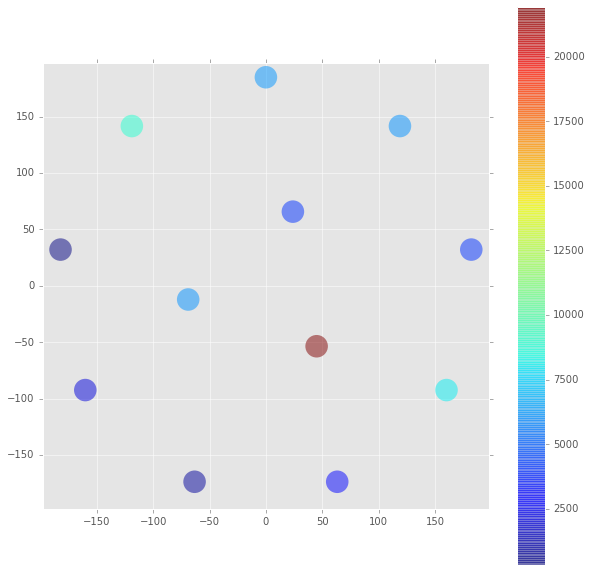

In [59]:
col =plot_sensor(sensor_df=dfPMT, energy_df=epsdf, event=0)

In [60]:
col

array([  4123.,   6146.,  21923.,   6164.,   8916.,    340.,   2030.,
          920.,   2866.,   8086.])

In [62]:
col

array([  4081.,   6169.,  22199.,   6030.,   8799.,    360.,   2064.,
          924.,   2954.,   8151.])

In [129]:
mchits['x'].values

array([-139.94728311, -139.71691735, -139.84105933, -139.90722967,
       -140.1827804 , -139.55963218, -139.63805949, -139.79416187,
       -139.80600703, -140.19603266, -139.90082315, -139.64089948,
       -139.57932506, -139.65088307, -139.4792594 , -139.60889824,
       -139.51429534, -139.46668514, -139.45004813, -139.48453752,
       -139.49661771, -139.49973123])

In [162]:
def plot_track(mchits,vox_sizeX=10, vox_sizeY=10, vox_sizeZ=10):
    """
    plot the hits of a mctrk
    """
    from mpl_toolkits.mplot3d import Axes3D
    
    vox_size = 10
    #grdcol = 0.99
    
    varr_x = mchits['x'].values*vox_sizeX;
    varr_y = mchits['y'].values*vox_sizeY;
    varr_z = mchits['z'].values*vox_sizeZ;
    varr_c = mchits['energy']
    
#     print("varr_x ={}".format(varr_x))
#     print("varr_y ={}".format(varr_y))
#     print("varr_z ={}".format(varr_z))

    # Plot the 3D voxelized track.
    fig = plt.figure(1);
    fig.set_figheight(6.);
    fig.set_figwidth(8.);

    
    ax1 = fig.add_subplot(111,projection='3d');
    s1 = ax1.scatter(varr_x,varr_y,varr_z,marker='s',linewidth=0.5,
                         s=2*vox_size,c=varr_c,cmap=plt.get_cmap('rainbow'),
                         vmin=0,vmax=max(varr_c));
    
    # this disables automatic setting of alpha relative of distance to camera
    s1.set_edgecolors = s1.set_facecolors = lambda *args:None;  
    min_x = np.min(varr_x)
    max_x = np.max(varr_x)
    min_y = np.min(varr_y)
    max_y = np.max(varr_y)
    min_z = np.min(varr_z)
    max_z = np.max(varr_z)
    
    print(" min_x ={} max_x ={}".format(min_x,max_x))
    print(" min_y ={} max_y ={}".format(min_y,max_y))
    print(" min_z ={} max_z ={}".format(min_z,max_z))
    
    #ax1.set_xlim([1.25*min_x, 1.25*max_x])
    #ax1.set_ylim([1.25*min_y, 1.25*max_y])
    #ax1.set_zlim([1.25*min_z, 1.25*max_z])
    
    #    ax1.set_xlim([0, 2 * vox_ext]);
    #    ax1.set_ylim([0, 2 * vox_ext]);
    #    ax1.set_zlim([0, 2 * vox_ext]);
    ax1.set_xlabel("x (mm)");
    ax1.set_ylabel("y (mm)");
    ax1.set_zlabel("z (mm)");
    ax1.set_title("");

    lb_x = ax1.get_xticklabels();
    lb_y = ax1.get_yticklabels();
    lb_z = ax1.get_zticklabels();
    for lb in (lb_x + lb_y + lb_z):
        lb.set_fontsize(8);
    
    ax1.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0));
    ax1.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0));
    ax1.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0));
#     ax1.w_xaxis._axinfo.update({'grid' : {'color': (grdcol, grdcol, grdcol, 1)}});
#     ax1.w_yaxis._axinfo.update({'grid' : {'color': (grdcol, grdcol, grdcol, 1)}});
#     ax1.w_zaxis._axinfo.update({'grid' : {'color': (grdcol, grdcol, grdcol, 1)}});
    
    cb1 = plt.colorbar(s1);
    cb1.set_label('Energy (keV)');
    
    plt.show()



In [140]:
mchits = get_mchits(mctrk,event_number = 12, particle_number =3)

In [141]:
mchits

,energy,time,x,y,z
0,0.015075,6.808364e+11,-26.191920,76.653807,11.802462
1,0.003341,6.808364e+11,-26.646669,77.250617,11.272663
2,0.015105,6.808364e+11,-26.998117,77.814815,10.631423
3,0.003273,6.808364e+11,-27.468663,78.319340,10.003694
4,0.005180,6.808364e+11,-27.757475,78.899627,9.345915
5,0.003423,6.808364e+11,-28.344137,79.453065,8.885828
6,0.004626,6.808364e+11,-28.601450,79.974001,8.166686
7,0.008368,6.808364e+11,-28.679091,80.562380,7.466461
8,0.004618,6.808364e+11,-28.706866,81.011184,6.673656
9,0.005444,6.808364e+11,-29.054867,81.765208,6.173552


 min_x =-29.677346221 max_x =-22.0913109435
 min_y =76.6538066267 max_y =88.5888708103
 min_z =0.740682050731 max_z =11.8024620344


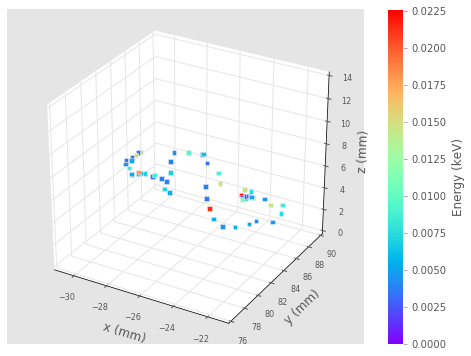

In [163]:
plot_track(mchits,vox_sizeX=1, vox_sizeY=1, vox_sizeZ=1)